This notebook is a simple walkthrough of what's possible with XArray for resonant scattering, and a demonstration of the library I've been developing.

The library has a few discrete modules:

1) File loaders.  These abstract away the details of getting raw data into a raw xarray and correcting the intensity (which lives here because it tends ot be metadata-intensive).  To add support for a new beamline you simply write a class that inherits from FileLoader with one method that opens the file, formats it into an xarray, and cleans up the metadata to include standard terms like exposure, energy, pos_x, pos_th, etc.

(optionally, data preprocessors like HDRSoXS exposure stitching can live between these two steps.)

2) Integrators.  These abstract away the details of conversion from a raw xarray to a chi,q xarray.  I provide a pyFAI based general purpose integrator (no parameters change within an array) and an energy series integrator (energy changes in an array and is handled efficiently).  Implementing other geometries (e.g. a detector moving) would be handled by subclassing the general integrator.  Implementing other backends (for example, pyGix) is also easy by just supporting the same integrateSingleImage(img) and integrateImageStack(img_stack) methods.

(you can slice the data here easily with standard xarray selector methods - as demonstrated below - or process it)

3) Fitting.  The fits are very simple to write, I provide a few demos here for lorentz and gauss peaks.  I think there are better curve fitting backends than scipy.optimize.curve_fit but that's what I used.


First, we import the modules we're going to use from my code:

In [3]:
from ALS11012RSoXSLoader import ALS11012RSoXSLoader

from PFEnergySeriesIntegrator import PFEnergySeriesIntegrator

Next, we configure the loader with dark images and correction details.

In [6]:
loader = ALS11012RSoXSLoader(corr_mode='none')
loader.loadSampleSpecificDarks("example_data/CCD/PSg/",samplenumber=11)

Loading dark for 0.00100000004749745 from L2_PSg_B_PZS_62757-00002.fits
Loading dark for 0.100000001490116 from L2_PSg_B_PZS_62757-00003.fits
Loading dark for 1.0 from L2_PSg_B_PZS_62757-00004.fits


Loading a single image is fairly straightforward, and let's pause here to look at the datastructure:

<xarray.DataArray (pix_x: 1024, pix_y: 1024)>
array([[1.5000e+01, 6.5530e+04, 6.5532e+04, ..., 6.5535e+04, 6.5500e+04,
        4.0000e+00],
       [6.5531e+04, 6.5531e+04, 5.0000e+00, ..., 0.0000e+00, 6.5534e+04,
        6.5525e+04],
       [9.0000e+00, 5.0000e+00, 6.5534e+04, ..., 6.5515e+04, 6.0000e+00,
        6.5535e+04],
       ...,
       [3.3000e+01, 4.4000e+01, 1.5000e+01, ..., 6.5531e+04, 2.6000e+01,
        1.4000e+01],
       [1.8000e+01, 1.7000e+01, 4.4000e+01, ..., 1.2000e+01, 6.5515e+04,
        1.1000e+01],
       [1.2000e+01, 9.0000e+00, 1.7000e+01, ..., 6.5533e+04, 6.5531e+04,
        9.0000e+00]])
Dimensions without coordinates: pix_x, pix_y
Attributes:
    SIMPLE:                         True
    BITPIX:                         8
    NAXIS:                          0
    EXTEND:                         True
    COMMENT:                            and Astrophysics', volume 376, page 3...
    EXPOSURE:                       1.0
    TEMP:                           -45.0
    RINGCRNT:                       500.06796875
    DATE:                           2019-12-05T17:19:08
    ROI_L:                          1309
    ROI_T:                          526
    ROI_R:                          2539
    ROI_B:                          1627
    EPU Polarization:               100.0
    Coolstage Temp C:               0.0
    CCD Temperature:                -45.0
    Beam Current:                   500.160429745629
    TEY signal:                     -0.00138802113572973
    IZERO:                          -0.757555848323469
    Photodiode:                     -0.0174490535949163
    AI 0:                           0.0106144069119131
    AI 3 Izero:                     0.271687146430482
    AI 5:                           0.270644818608554
    AI 6 BeamStop:                  -34.7838995460978
    AI 7:                           -0.00297954264795804
    Temperature Controller:         0.0
    PZT Shutter:                    0.0
    Pause Trigger:                  0.0
    LV Memory:                      345560.0
    Time Stamp Error:               -0.0127792358398438
    Time Stamp Transmit Time:       1.27750742062926
    Time Stamp Server Time:         0.722492579370737
    Sample Azimuthal Rotation:      0.0
    Piezo Vertical:                 0.0
    Piezo Horiz:                    0.0
    Sample X:                       0.802
    Sample Y:                       -16.977
    Sample Z:                       -2.0
    Sample Theta:                   90.0
    Sample Y Scaled:                -15.9531616230824
    CCD Theta:                      -1.219
    Beam Stop:                      -10.447
    Pollux CCD X:                   0.0
    Pollux CCD Y:                   0.0
    CCD X:                          99.83
    CCD Y:                          100.0
    CCD Temperature Setpoint:       -45.0
    T-2T:                           90.0
    Beamline Energy:                320.007148252393
    Mono 101 Grating:               -35.8435373725698
    Beamline Energy Goal:           0.0
    Entrance Slit width:            35.0
    Exit Slit Left:                 3608.0
    Exit Slit Right:                8910.0
    Horizontal Exit Slit Size:      1500.0
    Horizontal Exit Slit Position:  -700.0
    Vertical Exit Slit Size:        25.9000000000001
    Vertical Exit Slit Position:    0.259999999999991
    EPU Gap:                        29.1591625
    EPU Z:                          -5.00015258788771e-05
    Mono Energy:                    320.010228598141
    M103 Yaw:                       2.205
    M103 Bend Up:                   0.5595
    M103 Bend Down:                 1.0033
    M101 Feedback:                  0.0
    M101 Horizontal Deflection:     2.002
    M101 Vertical Deflection:       -13.504
    Vertical Slit Position:         0.259999999999991
    Vertical Slit Size:             25.9000000000001
    Horizontal Slit Position:       -700.0
    Mono 101 Vessel:                25.0
    Horizontal Slit Size:           15

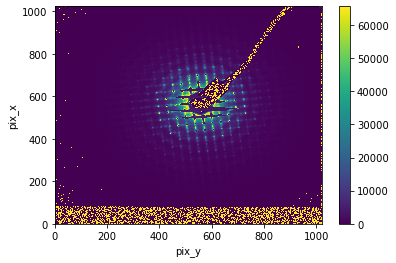

In [5]:
test_single_image = loader.loadSingleImage('../OrientationRunDec2019/CCD/PSg/L2_PSg_B_PZS_62757-00094.fits')
test_single_image.plot()
test_single_image

As you can see, the image is an xarray with dimensions pix_x and pix_y.  The metadata are all in "attributes" with some extra entries created with standard language.

My stack loader can use any entry in the single image attribute field as a coordinate of the dataset - meaning it can be selected on, sorted, etc.  You can also add arbitrary user data to the attributes via a simple interface.  Here's an example of that:

This is an example of how one might make an arbitrary user coordinate from info like the file name, in this case we'll just munge the exposure number from the name

In [8]:
import os 
files = os.listdir('../OrientationRunDec2019/CCD/PSg')

filenumber_coord = {}
for file in files:
    if '.fits' in file:
        filenumber_coord.update({file:int(file[-10:-5])})

What we just made is a dictionary of filename:number pairs - a coordinate!  You could use the filename to get other data, e.g. temperature, from an outside source.

To use this coordinate, you do two things. 

(1) Pass the {filename:value,filename:value} dict you created in coords, as an entry of another dict where the key is the name of the parameter, e.g.
'filenumber':filenumber coord.

(2) Tell the loader you want your new attribute to be used as a dimension of the resulting dataset by adding the name to dims.

So, next we're going to load a series.  The arguments here are path, dimensions (what axes we want the resulting xarray to have), coordinates (extra axes we generated, as above), and finally a metadata filter to suppress certain files.  In this case we only want a single sample number so we say to ignore files where sampleid is not 11.

In [9]:
raw_xr = loader.loadFileSeries(
                                '../OrientationRunDec2019/CCD/PSg/',
                               ['energy','polarization','exposure','filenumber'],
                               coords = {'filenumber':filenumber_coord},
                               md_filter={'sampleid':11,'CCD Shutter Inhibit':0}
                              )

Found 461 files.
Not loading L2_PSg_B_PZS_62758-00145.fits, expected sampleid to be 11 but it was 12.0
Not loading L2_PSg_B_PZS_62758-00112.fits, expected sampleid to be 11 but it was 12.0
Not loading L2_PSg_B_PZS_62758-00057.fits, expected sampleid to be 11 but it was 12.0
Not loading L2_PSg_B_PZS_62758-00104.fits, expected sampleid to be 11 but it was 12.0
Not loading L2_PSg_B_PZS_62758-00041.fits, expected sampleid to be 11 but it was 12.0
Not loading L2_PSg_B_PZS_62758-00153.fits, expected sampleid to be 11 but it was 12.0
Not loading L2_PSg_B_PZS_62758-00016.fits, expected sampleid to be 11 but it was 12.0
Not loading L2_PSg_B_PZS_62758-00082.fits, expected sampleid to be 11 but it was 12.0
Not loading L2_PSg_B_PZS_62758-00128.fits, expected sampleid to be 11 but it was 12.0
Not loading L2_PSg_B_PZS_62758-00201.fits, expected sampleid to be 11 but it was 12.0
Not loading L2_PSg_B_PZS_62758-00190.fits, expected sampleid to be 11 but it was 12.0
Not loading L2_PSg_B_PZS_62758-00256.

Let's look at this xarray:

In [10]:
raw_xr

<xarray.DataArray (system: 184, pix_x: 1024, pix_y: 1024)>
array([[[8.0000e+00, 6.5519e+04, 1.0000e+00, ..., 1.3000e+01,
         6.5493e+04, 2.0000e+00],
        [6.5521e+04, 6.5533e+04, 6.5534e+04, ..., 1.1000e+01,
         6.5531e+04, 2.0000e+00],
        [6.5535e+04, 1.1000e+01, 4.0000e+00, ..., 6.5525e+04,
         6.5524e+04, 6.5531e+04],
        ...,
        [2.2000e+01, 5.0000e+01, 2.9000e+01, ..., 6.5526e+04,
         3.4000e+01, 1.3000e+01],
        [3.4000e+01, 6.5000e+01, 3.7000e+01, ..., 3.0000e+00,
         6.5513e+04, 1.0000e+00],
        [2.9000e+01, 6.4000e+01, 2.5000e+01, ..., 6.5520e+04,
         6.5525e+04, 1.1000e+01]],

       [[1.0000e+01, 5.0000e+00, 6.5515e+04, ..., 5.0000e+00,
         6.5534e+04, 6.5532e+04],
        [8.0000e+00, 6.5526e+04, 6.5529e+04, ..., 1.6000e+01,
         0.0000e+00, 6.5524e+04],
        [6.5533e+04, 6.5535e+04, 1.6000e+01, ..., 6.5531e+04,
         0.0000e+00, 7.0000e+00],
        ...,
        [6.5529e+04, 6.0000e+00, 0.0000e+00, ..., 4.0000e+00,
         7.0000e+00, 6.5526e+04],
        [3.0000e+00, 1.3000e+01, 5.0000e+00, ..., 6.5535e+04,
         0.0000e+00, 8.0000e+00],
        [1.2000e+01, 3.0000e+00, 1.5000e+01, ..., 2.0000e+00,
         6.5522e+04, 6.5529e+04]],

       [[9.0000e+00, 6.5529e+04, 7.0000e+00, ..., 6.5533e+04,
         6.5481e+04, 6.5527e+04],
        [6.5520e+04, 6.5525e+04, 7.0000e+00, ..., 6.5530e+04,
         6.5531e+04, 6.5523e+04],
        [6.5522e+04, 1.0000e+01, 6.5521e+04, ..., 6.5534e+04,
         6.5524e+04, 6.5535e+04],
        ...,
        [1.7000e+01, 0.0000e+00, 2.0000e+00, ..., 6.5528e+04,
         2.9000e+01, 1.7000e+01],
        [6.5527e+04, 6.5533e+04, 1.6000e+01, ..., 1.9000e+01,
         6.5519e+04, 6.5533e+04],
        [2.2000e+01, 6.5534e+04, 1.0000e+00, ..., 6.5528e+04,
         6.5526e+04, 1.4000e+01]],

       ...,

       [[1.0000e+01, 1.0000e+00, 6.5519e+04, ..., 3.0000e+00,
         1.3000e+01, 6.5534e+04],
        [1.4000e+01, 6.5527e+04, 1.3000e+01, ..., 9.0000e+00,
         6.5534e+04, 6.5528e+04],
        [1.0000e+00, 6.5521e+04, 6.5518e+04, ..., 6.5527e+04,
         6.5528e+04, 1.1000e+01],
        ...,
        [6.5521e+04, 6.5527e+04, 1.7000e+01, ..., 6.5528e+04,
         1.6000e+01, 6.5519e+04],
        [4.0000e+00, 1.0000e+00, 6.5534e+04, ..., 6.5531e+04,
         2.0000e+00, 0.0000e+00],
        [1.9000e+01, 2.0000e+00, 6.0000e+00, ..., 6.5535e+04,
         6.5534e+04, 6.5533e+04]],

       [[7.0000e+00, 6.5528e+04, 6.5509e+04, ..., 6.5522e+04,
         6.5533e+04, 6.5533e+04],
        [2.0000e+00, 6.5525e+04, 8.0000e+00, ..., 2.3000e+01,
         1.0000e+00, 5.0000e+00],
        [6.5535e+04, 0.0000e+00, 6.5532e+04, ..., 6.5525e+04,
         6.5531e+04, 9.0000e+00],
        ...,
        [1.0000e+01, 6.5531e+04, 1.3000e+01, ..., 6.0000e+00,
         1.7000e+01, 6.5515e+04],
        [6.5531e+04, 6.5526e+04, 1.4000e+01, ..., 3.0000e+00,
         5.0000e+00, 1.0000e+00],
        [2.2000e+01, 9.0000e+00, 6.0000e+00, ..., 6.5531e+04,
         6.5525e+04, 6.5514e+04]],

       [[4.0000e+00, 3.0000e+00, 2.0000e+01, ..., 6.5525e+04,
         8.0000e+00, 6.5534e+04],
        [2.0000e+00, 6.0000e+00, 2.0000e+00, ..., 2.0000e+01,
         1.2000e+01, 9.0000e+00],
        [6.5529e+04, 0.0000e+00, 2.2000e+01, ..., 3.0000e+00,
         3.0000e+00, 1.6000e+01],
        ...,
        [6.5529e+04, 0.0000e+00, 6.5529e+04, ..., 6.5530e+04,
         1.3000e+01, 6.5528e+04],
        [5.0000e+00, 6.5532e+04, 6.5525e+04, ..., 6.5533e+04,
         1.4000e+01, 1.0000e+00],
        [8.0000e+00, 6.5528e+04, 7.0000e+00, ..., 6.5521e+04,
         6.5533e+04, 9.0000e+00]]])
Coordinates:
  * system        (system) MultiIndex
  - energy        (system) float64 310.0 284.5 292.0 291.0 ... 286.0 285.0 280.0
  - exposure      (system) float64 1.002 0.102 1.002 1.002 ... 0.102 0.102 0.003
  - filenumber    (system) int64 92 138 180 179 84 10 ... 101 44 117 52 140 5
  - polarization  (system) float64 100.0 190.0 190.0 190.0 ... 100.0 190.0 100.0
Dimensions

So, this is now a stack of 184 images in a single xarray.  We can use xarray selectors to punch out single images or subsets really easily:

In [9]:
raw_xr.sel(energy=320,polarization=100,method='nearest')

<xarray.DataArray (system: 2, pix_x: 1024, pix_y: 1024)>
array([[[1.4000e+01, 1.1000e+01, 6.5524e+04, ..., 6.5528e+04,
         6.5535e+04, 5.0000e+00],
        [9.0000e+00, 6.5523e+04, 0.0000e+00, ..., 2.9000e+01,
         1.1000e+01, 0.0000e+00],
        [1.0000e+00, 9.0000e+00, 1.2000e+01, ..., 6.5491e+04,
         6.5523e+04, 2.3000e+01],
        ...,
        [6.5520e+04, 4.0000e+00, 1.3000e+01, ..., 6.5522e+04,
         2.3000e+01, 6.5531e+04],
        [9.0000e+00, 6.5528e+04, 6.5531e+04, ..., 6.5533e+04,
         5.0000e+00, 8.0000e+00],
        [2.3000e+01, 1.5000e+01, 2.0000e+00, ..., 6.5521e+04,
         6.5521e+04, 6.5532e+04]],

       [[6.5525e+04, 1.0000e+01, 2.0000e+00, ..., 6.5511e+04,
         6.5525e+04, 5.0000e+00],
        [3.1000e+01, 2.0000e+00, 6.5529e+04, ..., 8.0000e+00,
         7.0000e+00, 2.0000e+01],
        [6.5532e+04, 5.0000e+00, 1.3000e+01, ..., 6.5533e+04,
         6.5531e+04, 6.5532e+04],
        ...,
        [6.5533e+04, 6.5531e+04, 7.0000e+00, ..., 7.0000e+00,
         1.5000e+01, 6.5524e+04],
        [4.0000e+00, 1.0000e+00, 6.5531e+04, ..., 6.5517e+04,
         0.0000e+00, 5.0000e+00],
        [6.5533e+04, 6.5530e+04, 3.0000e+00, ..., 6.5529e+04,
         6.5532e+04, 6.5535e+04]]])
Coordinates:
  * system      (system) MultiIndex
  - exposure    (system) float64 0.102 0.003
  - filenumber  (system) int64 76 32
Dimensions without coordinates: pix_x, pix_y
Attributes:
    SIMPLE:                         True
    BITPIX:                         8
    NAXIS:                          0
    EXTEND:                         True
    COMMENT:                            and Astrophysics', volume 376, page 3...
    EXPOSURE:                       1.0
    TEMP:                           -44.5
    RINGCRNT:                       500.060339355469
    DATE:                           2019-12-05T17:18:47
    ROI_L:                          1309
    ROI_T:                          526
    ROI_R:                          2539
    ROI_B:                          1627
    EPU Polarization:               100.0
    Coolstage Temp C:               0.0
    CCD Temperature:                -45.0
    Beam Current:                   500.132818603515
    TEY signal:                     -0.00136385642089821
    IZERO:                          -0.698759368088832
    Photodiode:                     -0.0174415487398088
    AI 0:                           0.0105281275274171
    AI 3 Izero:                     0.25842225556108
    AI 5:                           0.257279214499274
    AI 6 BeamStop:                  -35.2255056410498
    AI 7:                           -0.00296600067684033
    Temperature Controller:         0.0
    PZT Shutter:                    0.0
    Pause Trigger:                  0.0
    LV Memory:                      345552.0
    Time Stamp Error:               -0.0127792358398438
    Time Stamp Transmit Time:       1.27750742062926
    Time Stamp Server Time:         0.722492579370737
    Sample Azimuthal Rotation:      0.0
    Piezo Vertical:                 0.0
    Piezo Horiz:                    0.0
    Sample X:                       0.802
    Sample Y:                       -16.977
    Sample Z:                       -2.0
    Sample Theta:                   90.0
    Sample Y Scaled:                -15.9531616230824
    CCD Theta:                      -1.219
    Beam Stop:                      -10.447
    Pollux CCD X:                   0.0
    Pollux CCD Y:                   0.0
    CCD X:                          99.83
    CCD Y:                          100.0
    CCD Temperature Setpoint:       -45.0
    T-2T:                           90.0
    Beamline Energy:                309.999784281053
    Mono 101 Grating:               -36.1801606083782
    Beamline Energy Goal:           0.0
    Entrance Slit width:            35.0
    Exit Slit Left:                 3608.0
    Exit Slit Right:                8910.0
    Horizontal Exit Slit Size:      1500.0
    Horizontal Exit Slit Position:  -700.

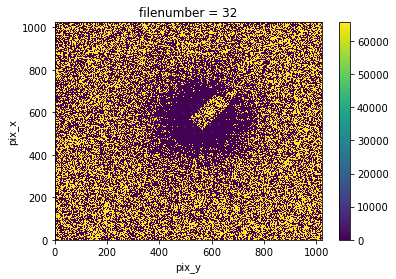

In [12]:
raw_xr.sel(energy=320,polarization=100,exposure=0.003,method='nearest').plot()

OK, let's try integrating this to get something useful!

We set up an integrator - the integrator supports calibrations from Nika and masks from Nika to make life easier.

In [14]:
integrator = PFEnergySeriesIntegrator(maskmethod = "nika",maskpath = "example_data/LowQ_mask.hdf",
                                 geomethod="nika",NIdistance=131.06, NIbcx=(561.76), NIbcy=(1024-452.33),
                                 
                                 integration_method='csr_ocl1,2')


Imported Nika mask, dimensions (1024, 1024)


Let's take our test image from before and integrate it:

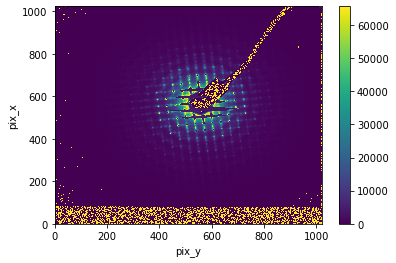

In [15]:
test_single_image.plot()

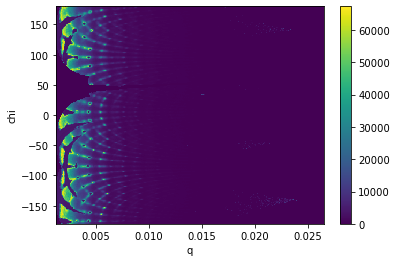

In [17]:
integrator.integrateSingleImage(test_single_image).plot()

We can integrate a whole stack of images really easily:

Note, because we're using the energy series integrator, we're internally pre-allocating integrator objects for each energy then using those for each image for speed.  All these details are abstracted.

In [18]:
int_xr = integrator.integrateImageStack(raw_xr)

In [19]:
int_xr

<xarray.DataArray (system: 184, chi: 360, q: 500)>
array([[[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * chi           (chi) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * q             (q) float64 2.377e-05 7.132e-05 0.0001189 ... 0.0237 0.02375
  * system        (system) MultiIndex
  - energy        (system) float64 310.0 284.5 292.0 291.0 ... 286.0 285.0 280.0
  - exposure      (system) float64 1.002 0.102 1.002 1.002 ... 0.102 0.102 0.003
  - filenumber    (system) int64 92 138 180 179 84 10 ... 101 44 117 52 140 5
  - polarization  (system) float64 100.0 190.0 190.0 190.0 ... 100.0 190.0 100.0
Attributes:
    SIMPLE:                         True
    BITPIX:                         8
    NAXIS:                          0
    EXTEND:                         True
    COMMENT:                            and Astrophysics', volume 376, page 3...
    EXPOSURE:                       1.0
    TEMP:                           -44.5
    RINGCRNT:                       500.060339355469
    DATE:                           2019-12-05T17:18:47
    ROI_L:                          1309
    ROI_T:                          526
    ROI_R:                          2539
    ROI_B:                          1627
    EPU Polarization:               100.0
    Coolstage Temp C:               0.0
    CCD Temperature:                -45.0
    Beam Current:                   500.132818603515
    TEY signal:                     -0.00136385642089821
    IZERO:                          -0.698759368088832
    Photodiode:                     -0.0174415487398088
    AI 0:                           0.0105281275274171
    AI 3 Izero:                     0.25842225556108
    AI 5:                           0.257279214499274
    AI 6 BeamStop:                  -35.2255056410498
    AI 7:                           -0.00296600067684033
    Temperature Controller:         0.0
    PZT Shutter:                    0.0
    Pause Trigger:                  0.0
    LV Memory:                      345552.0
    Time Stamp Error:               -0.0127792358398438
    Time Stamp Transmit Time:       1.27750742062926
    Time Stamp Server Time:         0.722492579370737
    Sample Azimuthal Rotation:      0.0
    Piezo Vertical:                 0.0
    Piezo Horiz:                    0.0
    Sample X:                

As with the raw data, we can slice this using standard select commands, and even plot using the core xarray plotting.

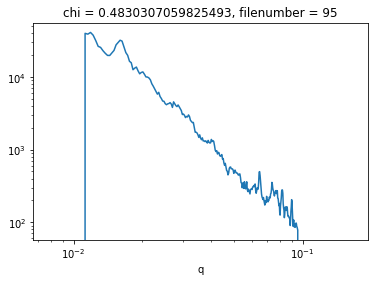

In [31]:
int_xr.sel(energy=270,polarization=100,exposure=1.002,method='nearest').sel(chi=0,method='nearest').plot(xscale='log',yscale='log')

We can use slicing to punch out energy scans, for example: (this gets a little gross, probably I need an xarray cleanup function)

In [140]:
pol100chi0 = int_xr.sel(polarization=100,chi=0,method='nearest')
pol100chi0

<xarray.DataArray (system: 92, q: 500)>
array([[nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    chi         float64 0.483
  * q           (q) float64 2.377e-05 7.132e-05 0.0001189 ... 0.0237 0.02375
  * system      (system) MultiIndex
  - energy      (system) float64 310.0 289.5 282.8 284.8 ... 284.0 286.0 280.0
  - exposure    (system) float64 1.002 1.002 0.003 0.102 ... 0.102 0.102 0.003
  - filenumber  (system) int64 92 84 10 47 51 6 71 26 ... 91 29 68 87 13 44 52 5
Attributes:
    SIMPLE:                         True
    BITPIX:                         8
    NAXIS:                          0
    EXTEND:                         True
    COMMENT:                            and Astrophysics', volume 376, page 3...
    EXPOSURE:                       1.0
    TEMP:                           -44.5
    RINGCRNT:                       500.060339355469
    DATE:                           2019-12-05T17:18:47
    ROI_L:                          1309
    ROI_T:                          526
    ROI_R:                          2539
    ROI_B:                          1627
    EPU Polarization:               100.0
    Coolstage Temp C:               0.0
    CCD Temperature:                -45.0
    Beam Current:                   500.132818603515
    TEY signal:                     -0.00136385642089821
    IZERO:                          -0.698759368088832
    Photodiode:                     -0.0174415487398088
    AI 0:                           0.0105281275274171
    AI 3 Izero:                     0.25842225556108
    AI 5:                           0.257279214499274
    AI 6 BeamStop:                  -35.2255056410498
    AI 7:                           -0.00296600067684033
    Temperature Controller:         0.0
    PZT Shutter:                    0.0
    Pause Trigger:                  0.0
    LV Memory:                      345552.0
    Time Stamp Error:               -0.0127792358398438
    Time Stamp Transmit Time:       1.27750742062926
    Time Stamp Server Time:         0.722492579370737
    Sample Azimuthal Rotation:      0.0
    Piezo Vertical:                 0.0
    Piezo Horiz:                    0.0
    Sample X:                       0.802
    Sample Y:                       -16.977
    Sample Z:                       -2.0
    Sample Theta:                   90.0
    Sample Y Scaled:                -15.9531616230824
    CCD Theta:                      -1.219
    Beam Stop:                      -10.447
    Pollux CCD X:                   0.0
    Pollux CCD Y:                   0.0
    CCD X:                          99.83
    CCD Y:                          100.0
    CCD Temperature Setpoint:       -45.0
    T-2T:                           90.0
    Beamline Energy:                309.999784281053
    Mono 101 Grating:               -36.1801606083782
    Beamline Energy Goal:           0.0
    Entrance Slit width:            35.0
    Exit Slit Left:                 3608.0
    Exit Slit Right:                8910.0
    Horizontal Exit Slit Size:      1500.0
    Horizontal Exit Slit Position:  -700.0
    Vertical Exit Slit Size:        25.9000000000001
    Vertical Exit Slit Position:    0.259999999999991
    EPU Gap:                        28.6995375
    EPU Z:                          -1.52587887711393e-09
    Mono Energy:                    309.999784281053
    M103 Yaw:                       2.205
    M103 Bend Up:                   0.5595
    M103 Bend Down:                 1.0033
    M101 Feedback:                  0.0
    M101 Horizontal Deflection:     2.002
    M101 Vertical Deflection:       -13.504
    Vertical Slit Position:         0.259999999999991
    Vertical Slit Size:             25.9000000000001
    Horizontal Slit Position:       -700.0
    Mono 101 Vessel:            

The one crude thing we have to do - remember that 'filenumber' axis we put in?  We need to get rid of it for auto-plotting to work... so we'll unstack the system multiindex (like a compound axis, done above) and select all values of the filenumber coordinate.  We also need to put the array in the right order for auto-plotting.

In [141]:
pol100chi0 = pol100chi0.sel(filenumber=slice(0,500)).sel(exposure=slice(0.8,1.1))
pol100chi0 = pol100chi0.drop('chi').sortby('energy').sortby('q')
pol100chi0

<xarray.DataArray (energy: 18, q: 500)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       ...,
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.]])
Coordinates:
  * q        (q) float64 2.377e-05 7.132e-05 0.0001189 ... 0.0237 0.02375
  * energy   (energy) float64 270.0 288.0 288.3 288.5 ... 310.0 315.0 320.0
Attributes:
    SIMPLE:                         True
    BITPIX:                         8
    NAXIS:                          0
    EXTEND:                         True
    COMMENT:                            and Astrophysics', volume 376, page 3...
    EXPOSURE:                       1.0
    TEMP:                           -44.5
    RINGCRNT:                       500.060339355469
    DATE:                           2019-12-05T17:18:47
    ROI_L:                          1309
    ROI_T:                          526
    ROI_R:                          2539
    ROI_B:                          1627
    EPU Polarization:               100.0
    Coolstage Temp C:               0.0
    CCD Temperature:                -45.0
    Beam Current:                   500.132818603515
    TEY signal:                     -0.00136385642089821
    IZERO:                          -0.698759368088832
    Photodiode:                     -0.0174415487398088
    AI 0:                           0.0105281275274171
    AI 3 Izero:                     0.25842225556108
    AI 5:                           0.257279214499274
    AI 6 BeamStop:                  -35.2255056410498
    AI 7:                           -0.00296600067684033
    Temperature Controller:         0.0
    PZT Shutter:                    0.0
    Pause Trigger:                  0.0
    LV Memory:                      345552.0
    Time Stamp Error:               -0.0127792358398438
    Time Stamp Transmit Time:       1.27750742062926
    Time Stamp Server Time:         0.722492579370737
    Sample Azimuthal Rotation:      0.0
    Piezo Vertical:                 0.0
    Piezo Horiz:                    0.0
    Sample X:                       0.802
    Sample Y:                       -16.977
    Sample Z:                       -2.0
    Sample Theta:                   90.0
    Sample Y Scaled:                -15.9531616230824
    CCD Theta:                      -1.219
    Beam Stop:                      -10.447
    Pollux CCD X:                   0.0
    Pollux CCD Y:                   0.0
    CCD X:                          99.83
    CCD Y:                          100.0
    CCD Temperature Setpoint:       -45.0
    T-2T:                           90.0
    Beamline Energy:                309.999784281053
    Mono 101 Grating:               -36.1801606083782
    Beamline Energy Goal:           0.0
    Entrance Slit width:            35.0
    Exit Slit Left:                 3608.0
    Exit Slit Right:                8910.0
    Horizontal Exit Slit Size:      1500.0
    Horizontal Exit Slit Position:  -700.0
    Vertical Exit Slit Size:        25.9000000000001
    Vertical Exit Slit Position:    0.259999999999991
    EPU Gap:                        28.6995375
    EPU Z:                          -1.52587887711393e-09
    Mono Energy:                    309.999784281053
    M103 Yaw:                       2.205
    M103 Bend Up:                   0.5595
    M103 Bend Down:                 1.0033
    M101 Feedback:                  0.0
    M101 Horizontal Deflection:     2.002
    M101 Vertical Deflection:       -13.504
    Vertical Slit Position:         0.259999999999991
    Vertical Slit Size:             25.9000000000001
    Horizontal Slit Position:       -700.0
    Mono 101 Vessel:                25.0
    Horizontal Slit Size:           1500.0
    Diag 106:                       95.0
    M121 Translation:               17.99971
    PiezoShutter Trans:             18.9567857142857
    Higher Order Suppressor:        7.500

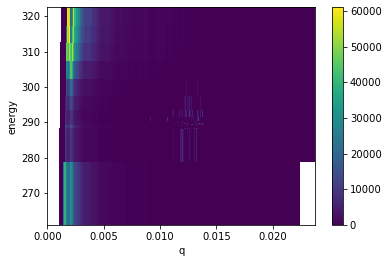

In [142]:
pol100chi0.plot()

For fitting, we can use the xarray split-apply-combine paradigm to automate things nicely.
Skipping the array prep for now, but here is the syntax.  This part is very much work in progress.

In [145]:
import Fitting
from Fitting import fit_lorentz_bg

In [277]:
lor0p002_p100_e0p1_chi0 = (pol100e0p1
       .coarsen(chi=10).mean()      #you can either coarsen chi (where number is an integer number of bins
                                     #over which to do a moving average), or
       #.sel(chi=0,method='nearest')  #you can just select a single chi stripe, if you do this, you can't stack
       .stack(echi=['energy','chi'])
       .sel(q=slice(0.0018,0.0025))
       .groupby('echi')
       .map(fit_lorentz_bg,guess=[0,0,0.0002,2e-8],pos_int_override=True)
       .unstack('echi'))
lor0p002_p100_e0p1_chim90 = (pol100e0p1
       #.coarsen(chi=15).mean()      #you can either coarsen chi (where number is an integer number of bins
                                     #over which to do a moving average), or
       .sel(chi=-90,method='nearest')  #you can just select a single chi stripe, if you do this, you can't stack
       .stack(echi=['energy'])#,'chi'])
       .sel(q=slice(0.0018,0.0025))
       .groupby('echi')
       .map(fit_lorentz,guess=[0,0,0.0002],pos_int_override=True)
       .unstack('echi'))



Starting fit on Coordinates:
    chi      float64 0.483
  * q        (q) float64 0.001839 0.001888 0.001937 ... 0.002426 0.002475
    echi     object (270.0,)
Fit completed, coeff = [5.58710261e-09 2.14143365e-03 1.28799515e-04 4.10084458e-09]
Starting fit on Coordinates:
    chi      float64 0.483
  * q        (q) float64 0.001839 0.001888 0.001937 ... 0.002426 0.002475
    echi     object (280.0,)
Fit completed, coeff = [1.22653626e-09 2.14293984e-03 1.36948357e-04 5.79321512e-10]
Starting fit on Coordinates:
    chi      float64 0.483
  * q        (q) float64 0.001839 0.001888 0.001937 ... 0.002426 0.002475
    echi     object (281.0,)
Fit completed, coeff = [5.35843435e-10 2.19031094e-03 1.05557154e-04 2.52267420e-10]
Starting fit on Coordinates:
    chi      float64 0.483
  * q        (q) float64 0.001839 0.001888 0.001937 ... 0.002426 0.002475
    echi     object (282.0,)
Fit completed, coeff = [ 2.63434223e-10  2.10201348e-03  5.36061360e-04 -1.38503819e-10]
Starting fit on Coor